In [1]:
# 패키지 불러오기
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import matplotlib.font_manager as fm

In [3]:
# 주피터 노트북 사용시 노트북 내부에 그림을 표시하도록 지정
%matplotlib inline

In [5]:
# 트렌드 영상에 오른 채널들 모든 영상 크롤링 데이터
total = pd.read_csv('C:/Users/김지희/DSL/dataset/channel_total.csv', lineterminator='\n')
trend_period = pd.read_csv('C:/Users/김지희/DSL/dataset/youtube_0723.csv', lineterminator='\n')
# 원래 데이터에서 모든 전처리가 완료된 데이터
trend = pd.read_csv('C:/Users/김지희/DSL/dataset/youtube_nodouble.csv', lineterminator='\n')
trend_unique = pd.read_csv('C:/Users/김지희/DSL/dataset/youtube_nodouble_unique.csv', lineterminator='\n')

In [6]:
# 나눔 바른 고딕 폰트 불러오기
import matplotlib.font_manager as fm
path = 'C:\\Windows\\Fonts\\NanumBarunGothic.ttf'  # 설치된 나눔글꼴중 원하는 녀석의 전체 경로를 가져오자
font_name = fm.FontProperties(fname=path, size=10).get_name()
print(font_name)
plt.rc('font', family=font_name)

NanumBarunGothic


In [8]:
# 기존데이터에서 모자랐던 정보들을 크롤링데이터에서 불러와 병합하기

trend_plus = pd.merge(trend_unique, total[['video_id', 'minute_time', 'seconds_time', 'totalview', 'subscriber']], left_on = 'video_id', right_on = 'video_id', how = 'left')

print(len(trend_plus['minute_time']))
print(trend_plus['minute_time'].isnull().sum())

16928
11885


# 채널별로 동영상을 올리는 간격의 분포 확인

In [18]:
# 전처리 하기 전 'when'의 형식을 확인해보자
total['when'].unique()

array(['10일 전', '8개월 전', '9개월 전', '10개월 전', '11개월 전', '1년 전', '6일 전',
       '13일 전', '2주 전', '1개월 전', '2개월 전', '3개월 전', '4개월 전', '5개월 전',
       '6개월 전', '7개월 전', '1일 전', '4일 전', '3주 전', '3일 전', '9일 전',
       '스트리밍 시간: 9개월 전', '20시간 전', '7일 전', '8일 전', '11일 전', '4주 전',
       '2일 전', '2년 전', '22시간 전', '12일 전', '29분 전', '5일 전', '8시간 전',
       '스트리밍 시간: 3개월 전', '스트리밍 시간: 4개월 전', '1시간 전', '4시간 전',
       '스트리밍 시간: 6일 전', '스트리밍 시간: 2주 전', '스트리밍 시간: 1개월 전',
       '스트리밍 시간: 2개월 전', '스트리밍 시간: 3일 전', '스트리밍 시간: 8일 전',
       '스트리밍 시간: 11일 전', '스트리밍 시간: 3주 전', '스트리밍 시간: 5개월 전',
       '스트리밍 시간: 6개월 전', '스트리밍 시간: 7개월 전', '스트리밍 시간: 9시간 전',
       '스트리밍 시간: 1일 전', '스트리밍 시간: 4일 전', '스트리밍 시간: 5일 전', '스트리밍 시간: 7일 전',
       '스트리밍 시간: 12일 전', '스트리밍 시간: 13일 전', '스트리밍 시간: 10개월 전', '49분 전',
       '18시간 전', '최초 공개일: 22. 7. 26. 19:00', '6시간 전', '스트리밍 시간: 11개월 전',
       '스트리밍 시간: 1년 전', '7시간 전', '3년 전', '5시간 전', '스트리밍 시간: 4주 전',
       '12시간 전', '스트리밍 시간: 47분 전', '47분 전', '2시간 전', '스트리밍 시간: 4시간 전',
   

In [19]:
# when의 형식을 바꾸는 함수 만들기
def replace_text(text): 
    if '초 전' in text:
        return int(text.replace('초 전', '')) * 0
    if '분 전' in text:
        return int(text.replace('분 전', '')) * 0
    elif '시간 전' in text:
        return int(text.replace('시간 전', '')) * 0
    elif '일 전' in text:
        return int(text.replace('일 전', ''))
    elif '개월 전' in text:
        return int(text.replace('개월 전', '')) * 30
    elif '년 전' in text:
        return int(text.replace('년 전', '')) * 365


In [20]:
def convert_when(text):
    if '최초 공개일' in text:
        text = text.replace('최초 공개일: ', '')
        text = '20'+text
        now = datetime.datetime.now()
        text = pd.to_datetime(text)
        date_diff = now - text
        return date_diff.days
    elif '스트리밍 시간' in text:
        text = text.replace('스트리밍 시간: ', '')
        return replace_text(text)
    else:
        return replace_text(text)
    

In [21]:
# 열에 함수 적용하기
total['upload_time'] = total['when'].apply(convert_when)

채널별로 기간을 분석을 하기 위해서 채널별로 when 열을 하나의 값으로 합치는 과정이 필요하다. 채택한 방법은 채널별로 when의 max값에서 min값을 빼고, 각 채널에 해당되는 영상수로 빼는 방법이다.

In [23]:
# 채널별로 max, min, count값을 생성하기
max_channel = total[['channelId', 'upload_time']].groupby(['channelId'], as_index=False).max()
min_channel = total[['channelId', 'upload_time']].groupby(['channelId'], as_index=False).min()
count_channel = total[['channelId', 'upload_time']].groupby(['channelId'], as_index=False).count()
print(max_channel.head())
print(min_channel.head())
print(count_channel.head())

                  channelId  upload_time
0  UC-0229MiVYnQoUxdLJnFl_g        365.0
1  UC-0C8yVGJy-cS4FGlYKelWw         60.0
2  UC-0tICWyA0_AJAVMBHL8GdQ        365.0
3  UC-2Y8dQb0S6DtpxNgAKoJKA         13.0
4  UC-2wa6jvprl7hfCpvw0ULzg        365.0
                  channelId  upload_time
0  UC-0229MiVYnQoUxdLJnFl_g          6.0
1  UC-0C8yVGJy-cS4FGlYKelWw          0.0
2  UC-0tICWyA0_AJAVMBHL8GdQ          0.0
3  UC-2Y8dQb0S6DtpxNgAKoJKA          0.0
4  UC-2wa6jvprl7hfCpvw0ULzg          5.0
                  channelId  upload_time
0  UC-0229MiVYnQoUxdLJnFl_g           60
1  UC-0C8yVGJy-cS4FGlYKelWw           75
2  UC-0tICWyA0_AJAVMBHL8GdQ           86
3  UC-2Y8dQb0S6DtpxNgAKoJKA           80
4  UC-2wa6jvprl7hfCpvw0ULzg           90


In [24]:
# 채널에 대한 max, min, upload_count 값을 하나의 dataframe으로 만들기
number_frame = pd.merge(max_channel, min_channel, left_on='channelId', right_on='channelId', how='outer')
number_frame = pd.merge(number_frame, count_channel, left_on='channelId', right_on='channelId', how='outer')

In [25]:
number_frame.columns = ['channelId', 'upload_max', 'upload_min','upload_count']

In [27]:
# 평균 기간에 대한 열을 만들기
number_frame['mean_period'] = (number_frame['upload_max'] - number_frame['upload_min'])/number_frame['upload_count']

In [29]:
number_frame = pd.merge(number_frame, trend_unique[['channelId', 'category_name']], left_on = 'channelId', right_on = 'channelId', how= 'right')
number_frame

,channelId,upload_max,upload_min,upload_count,mean_period,category_name
0,UCu9BCtGIEr73LXZsKmoujKw,365.0,10.0,60.0,5.916667,Entertainment
1,UCRuSxVu4iqTK5kCh90ntAgA,365.0,6.0,89.0,4.033708,Film & Animation
2,UCMVC92EOs9yDJG5JS-CMesQ,150.0,1.0,84.0,1.773810,People & Blogs
3,UCkQCwnkQfgSuPTTnw_Y7v7w,365.0,3.0,89.0,4.067416,Entertainment
4,UCaO6TYtlC8U5ttz62hTrZgg,240.0,0.0,80.0,3.000000,Music
...,...,...,...,...,...,...
16923,UCw1DsweY9b2AKGjV4kGJP1A,9.0,0.0,90.0,0.100000,Gaming
16924,UCw1DsweY9b2AKGjV4kGJP1A,9.0,0.0,90.0,0.100000,Gaming
16925,UCLhgIX2L5ZCaWdlaxR_oTAg,240.0,1.0,82.0,2.914634,Film & Animation
16926,UCsXigGjbC_l4ttk-oahTfVg,1095.0,30.0,72.0,14.791667,Music


In [30]:
number_frame['mean_period'].describe()

count    15439.000000
mean         3.528153
std          6.784721
min          0.000000
25%          0.714286
50%          2.333333
75%          4.102273
max        342.500000
Name: mean_period, dtype: float64

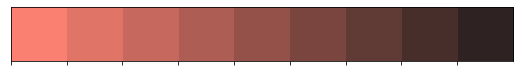

In [36]:
custom_palette = sns.color_palette("dark:salmon_r", 9)
sns.palplot(custom_palette)

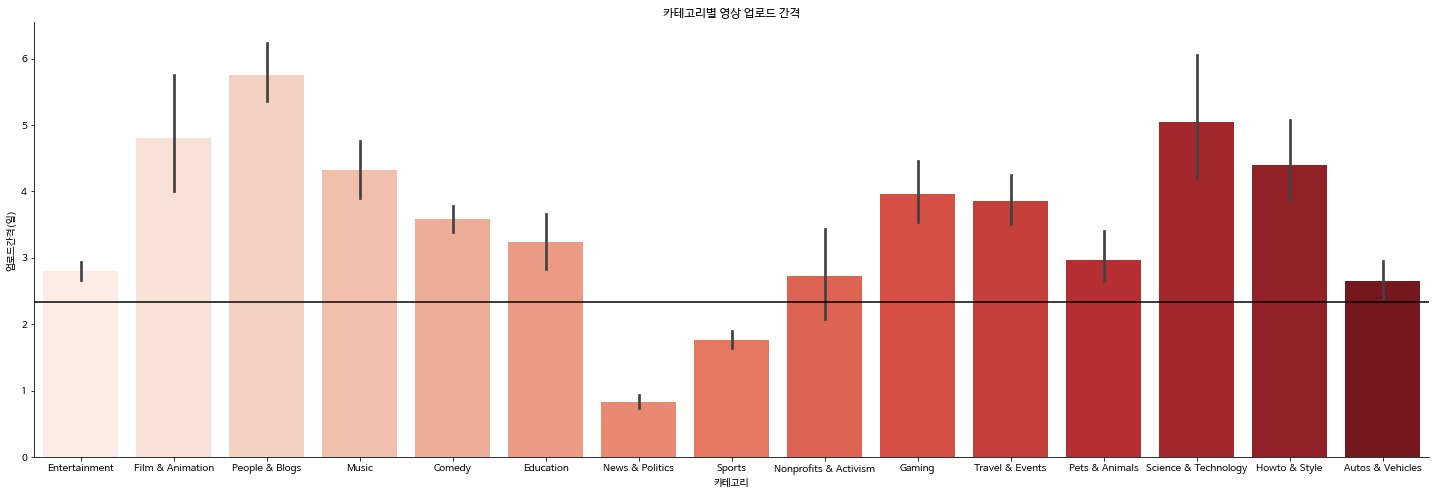

In [52]:
# 카테고리별 영상 업로드 차이 보기
plt.figure(figsize = (25,8))

sns.barplot(data=number_frame, x = 'category_name', y = 'mean_period', palette='Reds')
plt.axhline(y=2.3333, color='black', linestyle='solid')

# plt.xticks(fontsize = 12) 
plt.title('카테고리별 영상 업로드 간격')
plt.ylabel('업로드간격(일)')
plt.xlabel('카테고리')
sns.despine()
plt.show()